# Pre-processing and Feature Extraction
Involves tasks concerning text cleaning, lemmatization and extracting feature which are used in Notebook6 

In [1]:
import nltk
import pandas as pd
# import re
import string
import contractions
import os
from nltk import word_tokenize, sent_tokenize
# from nltk.corpus import stopwords
from nltk.stem import  WordNetLemmatizer
import inflect
# os.chdir('/home/rinkita/courses/NLPSeminar/nlp-quora-kaggle')
# nltk.download('punkt')
# nltk.download('stopwords')
from tqdm import tqdm
tqdm.pandas()
import collections
import re

import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv("./data/balanced_train.csv")
x_train=data.question_text


In [3]:
x_train.head()

0    Can organs be donated even after the person ha...
1    Knowing what we do now about evolution and the...
2                 Is it ok to smoke a cigarette naked?
3                       How we attempt CBSE questions?
4            Will rooting my phone void it's warranty?
Name: question_text, dtype: object

In [4]:
data.target.value_counts()

1    80810
0    80810
Name: target, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161620 entries, 0 to 161619
Data columns (total 3 columns):
qid              161620 non-null object
question_text    161620 non-null object
target           161620 non-null int64
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


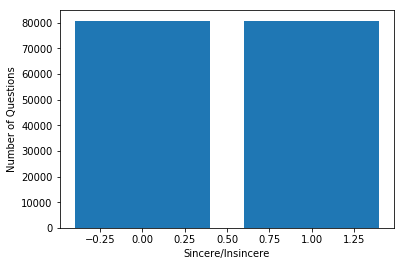

In [ ]:
target_count=data.groupby('target').count()
plt.bar(target_count.index.values, target_count['question_text'])
plt.xlabel('Sincere/Insincere')
plt.ylabel('Number of Questions')
plt.show()

In [ ]:
# """Replace contractions in string of text"""
contracted_input = x_train.progress_apply(lambda row:contractions.fix(row))

100%|██████████| 161620/161620 [00:47<00:00, 3400.30it/s]


# Text Cleaning

In [ ]:
def clean_text(question_text):
    question_text = question_text.translate(str.maketrans('','',string.punctuation))
    question_text = question_text.translate(str.maketrans('','','1234567890'))
    question_text = " ".join(question_text.split())    
    question_text = question_text.split()
    #stop_words = set(stopwords.words('english'))
    #question_text = [w for w in question_text if not w in stop_words and len(w) >= 3]
    question_text = [w for w in question_text if len(w) >= 3]
    question_text = [w.strip('/"“”') for w in question_text ]
    question_text = " ".join(question_text)
    return question_text


# Lemmatization

In [ ]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

# Spell Correction

In [ ]:
def tokens(text):
    """
    Get all words from corpus
    """
    return re.findall(r'\w+', text)

WORDS = tokens(open("./data/words_alpha.txt", 'r').read())
WORD_COUNTS = collections.Counter(WORDS)

In [ ]:
def edits0(word):
    """
    Return all strings that are zero edits away (i.e. the word itself).
    """
    return{word}

def edits1(word):
    """
    Return all strings that are one edits away.
    """
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    def splits(word):
        """
        return a list of all possible pairs
        that the input word is made of
        """
        return [(word[:i], word[i:]) for i in range(len(word)+1)]
    pairs = splits(word)
    deletes = [a+b[1:] for (a,b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a,b) in pairs if len(b) >1]
    replaces = [a+c+b[1:] for (a,b) in pairs for c in alphabet if b]
    inserts = [a+c+b for (a,b) in pairs for c in alphabet]
    return(set(deletes + transposes + replaces + inserts))

def edits2(word):
    """
    return all strings that are two edits away.
    """
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

def known(words):
    return {w for w in words if w in WORD_COUNTS}

In [ ]:
def correct(word):
    candidates = (known(edits0(word)) or
                 known(edits1(word)) or
                 known(edits2(word)) or
                 [word])
    return max(candidates, key=WORD_COUNTS.get)

In [ ]:
def correct_match(match):#
    """
    spell-correct word in match, 
    and perserve upper/lower/title case
    """
    word = match.group()
    def case_of(text):
        return(str.upper if text.isupper() else
              str.lower if text.islower() else
              str.title if text.istitle() else
              str)
    return case_of(word)(correct(word.lower()))

def correct_text_generic(text):
    """
    correct all words in text
    """
    return re.sub('[a-zA-Z]+', correct_match, text)

In [ ]:
cleaned_text = contracted_input.progress_apply(lambda row:clean_text(row))

100%|██████████| 161620/161620 [00:04<00:00, 33668.50it/s]


In [ ]:

word_tokenised = cleaned_text.progress_apply(lambda text:nltk.word_tokenize(text))


100%|██████████| 161620/161620 [00:48<00:00, 3353.42it/s]


In [ ]:
lemmatized_words = word_tokenised.progress_apply(lambda word_list:lemmatize_verbs(word_list))

 67%|██████▋   | 107576/161620 [00:10<00:04, 11068.04it/s]

In [ ]:
lemmatized_words.head()

# Feature Extraction

In [ ]:


def extract_features(question_texts):  
    word2index = {}
    word2count = {}
    index2word = {0: "pad"}
    n_words = 1  # Count SOS and EOS
    for text in question_texts:
        for word in text:             
            if word not in word2index:
                word2index[word] = n_words
                word2count[word] = 1
                index2word[n_words] = word
                n_words += 1
            else:
                word2count[word] += 1
    return word2index,word2count,index2word,n_words

    

#make all the input text of the same size as size max_length input senetnce, padding with word "PAD"(zero padding)
def make_input(sentence, time_stamp):
    sent_len = len(sentence.split(' '))
    if sent_len < time_stamp:
        padded_sentence = sentence + (time_stamp - len(sentence.split(' '))) * " PAD"
    else:
        padded_sentence = sentence

    return padded_sentence,sent_len

In [ ]:
word2index,word2count,index2word,n_words = extract_features(lemmatized_words)